# Freight Pricing API Time Series Example

This Jupyter Notebook displays a use case of how we could use the Freight Pricing API in order to conduct a time series analysis regarding the freight rates.
But first we should make sure that the Signal Ocean SDK is installed.

Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
pip install signal-ocean

In [2]:
signal_ocean_api_key = '' #replace with your subscription key

In [3]:
from signal_ocean import Connection
connection = Connection(api_key=signal_ocean_api_key)

In [4]:
from signal_ocean.freight_pricing import FreightPricingAPI

freight_pricing_api = FreightPricingAPI(connection)

We will use PortFilter module in order to set the loading and discharge port, as well as VesselTypeFilter to get the vessel type we want.

In [5]:
from signal_ocean.freight_pricing import FreightPricingAPI
from signal_ocean.freight_pricing import VesselTypeFilter, VesselClassFilter, PortFilter, VesselSubclass

load_port = freight_pricing_api.get_ports(PortFilter(name_like='Gamba'))[0]
discharge_port = freight_pricing_api.get_ports(PortFilter(name_like='Singapore'))[0]

vessel_type = freight_pricing_api.get_vessel_types(VesselTypeFilter(name_like='Tank'))[0]

In [6]:
from pandas import options
options.display.float_format = "{:,.2f}".format

### Creating Time Series Data 

Time Series data are created by calling the Freight Pricing API iteratively. Τime Window and Frequency are determined by first_day, last_day and weeks_before variables. In this specific example we will get the freight rates for every week for the last 52 weeks. Reference day is the present day of week.

In [7]:
import pandas as pd
import datetime as dt

last_day = dt.date.today() + pd.DateOffset(days= -1) #- pd.DateOffset(days= (- or +)...) To pick a specific date
weeks_before = 52 # here the number of weeks back can change
first_day = last_day + pd.DateOffset(days= -weeks_before*7)

df_dict = {}

for i in range(1,weeks_before+1):
    next_date = first_day + pd.DateOffset(days=i*7)
    freight_pricing_collection = freight_pricing_api.get_freight_pricing(
        vessel_type=vessel_type,
        load_port=load_port, 
        discharge_port=discharge_port,
        date=next_date,
        vessel_subclass=VesselSubclass.DIRTY)
    temp_dict = [o.__dict__ for o in freight_pricing_collection]
    for item in temp_dict:
        item['costs']= item['costs'].__dict__ 
        item['totals']= item['totals'].__dict__ 
    dataf = pd.json_normalize(data=temp_dict)
    fr_series = dataf['costs.freight_rate']
    df_dict[str(next_date)] = fr_series.values.tolist()
    
vessel_classes = dataf.vessel_class.tolist()
df_dict["vessel_class"] = vessel_classes

In [8]:
import numpy as np

data_types = {key:np.float for key in df_dict.keys()}
data_types["vessel_class"] = 'str'


In [9]:
final_df = pd.DataFrame.from_dict(df_dict).astype(data_types)
final_df

,2020-03-30 00:00:00,2020-04-06 00:00:00,2020-04-13 00:00:00,2020-04-20 00:00:00,2020-04-27 00:00:00,2020-05-04 00:00:00,2020-05-11 00:00:00,2020-05-18 00:00:00,2020-05-25 00:00:00,2020-06-01 00:00:00,...,2021-01-25 00:00:00,2021-02-01 00:00:00,2021-02-08 00:00:00,2021-02-15 00:00:00,2021-02-22 00:00:00,2021-03-01 00:00:00,2021-03-08 00:00:00,2021-03-15 00:00:00,2021-03-22 00:00:00,vessel_class
0,31.66,54.51,40.05,38.40,43.22,27.94,16.38,15.83,15.14,18.31,...,8.56,9.02,8.33,7.99,8.67,8.45,8.45,7.99,7.99,VLCC
1,35.93,49.00,36.61,37.99,52.44,34.55,26.98,28.35,21.47,22.16,...,15.52,16.09,13.70,13.70,14.84,14.50,15.07,17.12,17.12,Suezmax
2,46.52,46.52,27.25,27.25,63.04,47.90,35.51,26.01,26.01,26.01,...,17.69,20.54,21.69,21.69,26.02,29.45,25.68,25.68,30.02,Aframax


Transposed dataframe is helpfull for the visualization of the data

In [10]:
final_df_transposed = final_df.set_index("vessel_class").T.rename_axis('Date')
final_df_transposed.head()

vessel_class,VLCC,Suezmax,Aframax
Date,,,
2020-03-30 00:00:00,31.66,35.93,46.52
2020-04-06 00:00:00,54.51,49.00,46.52
2020-04-13 00:00:00,40.05,36.61,27.25
2020-04-20 00:00:00,38.40,37.99,27.25
2020-04-27 00:00:00,43.22,52.44,63.04


In [11]:
# extracting the transposed ton an excel file
final_df.to_excel('simpleDemoFreightPricing.xlsx')

## Visualizing the results in a graph

In [12]:
# creating x axis for the graph
variables_dict={}
for vc in  final_df.vessel_class.tolist():
    variables_dict["var%s" %vc] = final_df.loc[final_df.vessel_class==vc,str(first_day):str(last_day)].values.tolist()[0]

x_axis = final_df.loc[1:-1,str(first_day):str(last_day)].columns.tolist()
x_axis = [dt.datetime.strptime(x[0:10], '%Y-%m-%d') for x in x_axis]


In [13]:
#restrain the y axis
import numpy as np

minim = np.amin(final_df.loc[:,str(first_day):str(last_day)].values)
maxim = np.amax(final_df.loc[:,str(first_day):str(last_day)].values)

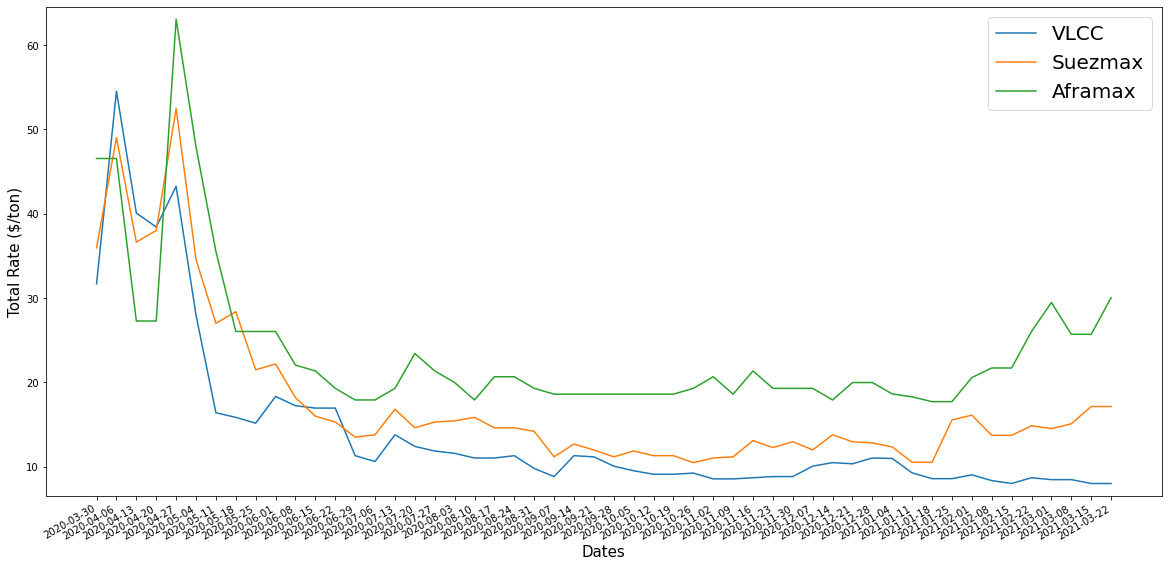

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.axes.set_ylim([minim - 1.5 ,maxim + 1.5])
ax.axes.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

for key,val in variables_dict.items():
    ax.plot(x_axis,val,label=key[3:])

plt.xticks(x_axis)

plt.xlabel("Dates", fontsize=15)
plt.ylabel("Total Rate ($/ton)", fontsize=15)

plt.legend(fontsize=20)

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()